In [3]:
#nathan's 3060ish card
!nvidia-smi

Sat Feb 28 23:17:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


|   0  NVIDIA Graphics Device         Off |   00000000:01:00.0 Off |                  N/A |
|  0%   38C    P8              7W /  170W |       4MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|  No running processes found                                                     

In [19]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
seed=42
torch.manual_seed(seed)
device

'cuda'

In [ ]:
# personally i use l(learn) as training data and t(test) as testing data
l_data=FashionMNIST(
    root="data", #download loc
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

t_data=FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [11]:
len(l_data), len(t_data)

(60000, 10000)

In [ ]:
img,tag=l_data[0]
#channle * hight * width, tag is the label of the image
img.shape, tag

(torch.Size([1, 28, 28]), 9)

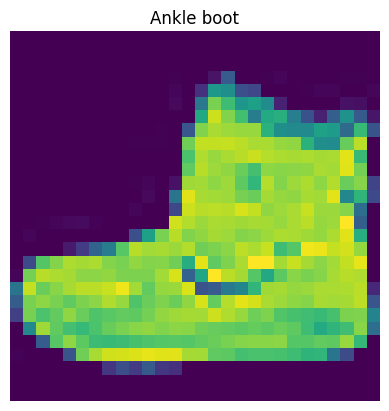

In [16]:
plt.imshow(img.squeeze());
plt.title(l_data.classes[tag]);
plt.axis(False);

In [18]:
len(l_data.classes)

10